# Mobility data anlaysis (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   scipy.stats import permutation_test
import seaborn as sns
from   sklearn.preprocessing import LabelBinarizer
import string
import warnings

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
metadata_dir = os.path.join(data_dir, 'metadata')

# settings
conlit_file = 'CONLIT_CharData_AP_MW_7.csv.gz'
early_file  = 'EARLY_CharData_AP_MW_7.csv.gz'

## Load data

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

# read CONLIT
conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit.replace([np.inf, -np.inf], np.nan, inplace=True)
conlit.rename(columns={'source':'collection'}, inplace=True)

# read EARLY
early = pd.read_csv(
    os.path.join(derived_dir, early_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early.replace([np.inf, -np.inf], np.nan, inplace=True)

## Feature differences by facet 

### CONLIT

In [3]:
def significance_label(pvalue, levels=[0.05, 0.01, 0.001]):
    if pvalue < levels[2]:
        return '***'
    elif pvalue < levels[1]:
        return '**'
    elif pvalue < levels[0]:
        return '*'
    else: 
        return ''

def diff_means(x, y, axis):
    return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)

def compare_facets(df, facets, cols_to_drop, statistic=diff_means):
    '''Compare statistic in numeric cols of df via permutation. Display results, return nothing.'''
    cols = df.select_dtypes(include='number').drop(columns=cols_to_drop).columns
    for facet in facets:
        print(f"\n==============\nFacet: {facet}\n==============")
        df = df.dropna(subset=[facet])
        for level in df[facet].unique():
            data = (df.loc[df[facet]==level, cols], df.loc[~(df[facet]==level), cols])
            level_mean = np.mean(data[0], axis=0)
            other_mean = np.mean(data[1], axis=0)
            output = pd.DataFrame(level_mean, columns=[level]).join(pd.DataFrame(other_mean, columns=['others']))
            res = permutation_test(data, statistic, n_resamples=2500)
            output['diff'] = res.statistic
            output['p'] = res.pvalue
            output['sig'] = output['p'].apply(significance_label)
            display(output)

In [4]:
facet_by = ['inf_gender', 'Category', 'Genre', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank', 'num_words']
compare_facets(conlit, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
char_count,3752.279775,3844.495428,-92.215652,0.382247,
num_gpe_places,16.356180,21.814954,-5.458775,0.000800,***
num_nongpe_places,122.757303,123.285637,-0.528334,0.863655,
num_all_places,138.620225,144.524476,-5.904251,0.104758,
dist_miles,51501.447552,72756.670191,-21255.222639,0.000800,***
Tokens,119516.989888,131900.656267,-12383.666379,0.000800,***
num_gpe_places_norm,0.000141,0.000170,-0.000029,0.000800,***
num_nongpe_places_norm,0.001127,0.001048,0.000079,0.002399,**
num_gpe_places_norm_byCharacter,0.005224,0.009569,-0.004345,0.000800,***
num_nongpe_places_norm_byCharacter,0.036178,0.037657,-0.001479,0.035986,*


,he/him/his,others,diff,p,sig
char_count,4012.726801,3475.705128,537.021673,0.000800,***
num_gpe_places,22.025360,16.663708,5.361652,0.000800,***
num_nongpe_places,127.342939,115.879684,11.463255,0.000800,***
num_all_places,148.785591,132.051282,16.734309,0.000800,***
dist_miles,73533.779439,52771.036370,20762.743069,0.000800,***
Tokens,133472.337752,118342.144970,15130.192782,0.000800,***
num_gpe_places_norm,0.000169,0.000146,0.000023,0.000800,***
num_nongpe_places_norm,0.001073,0.001074,-0.000001,0.958017,
num_gpe_places_norm_byCharacter,0.008396,0.007762,0.000634,0.185526,
num_nongpe_places_norm_byCharacter,0.036880,0.037687,-0.000807,0.254298,


,they/them/their,others,diff,p,sig
char_count,1490.612903,3924.422857,-2433.809954,0.000800,***
num_gpe_places,18.870968,20.103238,-1.232270,0.549380,
num_nongpe_places,66.516129,125.788190,-59.272061,0.000800,***
num_all_places,84.903226,145.339048,-60.435822,0.000800,***
dist_miles,61883.407727,66063.769770,-4180.362043,0.703719,
Tokens,109909.790323,128740.810286,-18831.019963,0.002399,**
num_gpe_places_norm,0.000183,0.000160,0.000024,0.071971,
num_nongpe_places_norm,0.000695,0.001091,-0.000396,0.000800,***
num_gpe_places_norm_byCharacter,0.025981,0.007321,0.018660,0.000800,***
num_nongpe_places_norm_byCharacter,0.048523,0.036642,0.011881,0.000800,***



Facet: Category


,FIC,others,diff,p,sig
char_count,4206.708441,2889.110024,1317.598417,0.000800,***
num_gpe_places,13.348006,35.863081,-22.515074,0.000800,***
num_nongpe_places,123.981875,121.067237,2.914638,0.348661,
num_all_places,136.915070,156.063570,-19.148500,0.000800,***
dist_miles,38036.039103,131593.333370,-93557.294267,0.000800,***
Tokens,121689.747281,142531.221271,-20841.473990,0.000800,***
num_gpe_places_norm,0.000117,0.000263,-0.000146,0.000800,***
num_nongpe_places_norm,0.001116,0.000972,0.000144,0.000800,***
num_gpe_places_norm_byCharacter,0.003801,0.018457,-0.014656,0.000800,***
num_nongpe_places_norm_byCharacter,0.033272,0.046399,-0.013127,0.000800,***


,NON,others,diff,p,sig
char_count,2889.110024,4206.708441,-1317.598417,0.000800,***
num_gpe_places,35.863081,13.348006,22.515074,0.000800,***
num_nongpe_places,121.067237,123.981875,-2.914638,0.355858,
num_all_places,156.063570,136.915070,19.148500,0.000800,***
dist_miles,131593.333370,38036.039103,93557.294267,0.000800,***
Tokens,142531.221271,121689.747281,20841.473990,0.000800,***
num_gpe_places_norm,0.000263,0.000117,0.000146,0.000800,***
num_nongpe_places_norm,0.000972,0.001116,-0.000144,0.000800,***
num_gpe_places_norm_byCharacter,0.018457,0.003801,0.014656,0.000800,***
num_nongpe_places_norm_byCharacter,0.046399,0.033272,0.013127,0.000800,***



Facet: Genre


,YA,others,diff,p,sig
char_count,5664.129944,3687.361975,1976.767968,0.000800,***
num_gpe_places,11.519774,20.634526,-9.114752,0.000800,***
num_nongpe_places,130.824859,122.583981,8.240877,0.164734,
num_all_places,141.903955,142.661742,-0.757787,0.909236,
dist_miles,28737.615271,68430.941020,-39693.325749,0.000800,***
Tokens,106057.067797,129393.989114,-23336.921317,0.000800,***
num_gpe_places_norm,0.000113,0.000164,-0.000051,0.000800,***
num_nongpe_places_norm,0.001257,0.001061,0.000196,0.000800,***
num_gpe_places_norm_byCharacter,0.002359,0.008562,-0.006202,0.000800,***
num_nongpe_places_norm_byCharacter,0.024377,0.038059,-0.013682,0.000800,***


,SF,others,diff,p,sig
char_count,3852.243243,3811.336763,40.906480,0.805278,
num_gpe_places,12.747748,20.688959,-7.941211,0.000800,***
num_nongpe_places,116.711712,123.677087,-6.965376,0.195922,
num_all_places,128.842342,143.822715,-14.980372,0.027189,*
dist_miles,31137.835935,68926.924665,-37789.088730,0.000800,***
Tokens,144376.954955,126443.117135,17933.837820,0.000800,***
num_gpe_places_norm,0.000098,0.000166,-0.000068,0.000800,***
num_nongpe_places_norm,0.000902,0.001088,-0.000186,0.000800,***
num_gpe_places_norm_byCharacter,0.003721,0.008553,-0.004831,0.000800,***
num_nongpe_places_norm_byCharacter,0.031815,0.037649,-0.005835,0.000800,***


,BS,others,diff,p,sig
char_count,4729.730924,3723.497200,1006.233724,0.000800,***
num_gpe_places,17.694779,20.282000,-2.587221,0.052779,
num_nongpe_places,143.425703,121.091600,22.334103,0.000800,***
num_all_places,160.618474,140.819600,19.798874,0.000800,***
dist_miles,49632.755582,67492.952826,-17860.197244,0.005598,**
Tokens,155119.140562,125179.510000,29939.630562,0.000800,***
num_gpe_places_norm,0.000126,0.000164,-0.000038,0.000800,***
num_nongpe_places_norm,0.001017,0.001079,-0.000062,0.122351,
num_gpe_places_norm_byCharacter,0.004617,0.008516,-0.003899,0.000800,***
num_nongpe_places_norm_byCharacter,0.034983,0.037397,-0.002413,0.042383,*


,NYT,others,diff,p,sig
char_count,3719.703349,3831.664522,-111.961172,0.440624,
num_gpe_places,16.351675,20.710425,-4.358750,0.001599,**
num_nongpe_places,129.624402,121.947233,7.677169,0.059976,
num_all_places,145.581340,142.080652,3.500688,0.451020,
dist_miles,52104.402460,68344.615177,-16240.212717,0.002399,**
Tokens,118268.789474,129616.939940,-11348.150466,0.000800,***
num_gpe_places_norm,0.000150,0.000163,-0.000013,0.088764,
num_nongpe_places_norm,0.001194,0.001052,0.000142,0.000800,***
num_gpe_places_norm_byCharacter,0.004899,0.008748,-0.003848,0.000800,***
num_nongpe_places_norm_byCharacter,0.037954,0.037039,0.000915,0.352659,


,MY,others,diff,p,sig
char_count,4099.149573,3788.168986,310.980587,0.098361,
num_gpe_places,13.286325,20.676740,-7.390415,0.000800,***
num_nongpe_places,132.316239,122.258449,10.057790,0.045582,*
num_all_places,145.226496,142.369781,2.856714,0.630948,
dist_miles,33531.764764,68884.495129,-35352.730365,0.000800,***
Tokens,124630.961538,128194.749901,-3563.788362,0.437425,
num_gpe_places_norm,0.000109,0.000166,-0.000057,0.000800,***
num_nongpe_places_norm,0.001113,0.001070,0.000044,0.288685,
num_gpe_places_norm_byCharacter,0.003733,0.008574,-0.004841,0.000800,***
num_nongpe_places_norm_byCharacter,0.034180,0.037457,-0.003277,0.005598,**


,ROM,others,diff,p,sig
char_count,5970.480769,3638.168438,2332.312332,0.000800,***
num_gpe_places,7.625000,21.064542,-13.439542,0.000800,***
num_nongpe_places,108.990385,124.270760,-15.280375,0.006397,**
num_all_places,116.403846,144.758363,-28.354517,0.000800,***
dist_miles,20950.401077,69552.638639,-48602.237562,0.000800,***
Tokens,103573.639423,129881.985045,-26308.345622,0.000800,***
num_gpe_places_norm,0.000075,0.000168,-0.000093,0.000800,***
num_nongpe_places_norm,0.001099,0.001071,0.000028,0.526989,
num_gpe_places_norm_byCharacter,0.001397,0.008716,-0.007319,0.000800,***
num_nongpe_places_norm_byCharacter,0.019871,0.038595,-0.018724,0.000800,***


,HIST,others,diff,p,sig
char_count,987.385366,4042.465409,-3055.080043,0.000800,***
num_gpe_places,20.839024,19.983884,0.855141,0.560576,
num_nongpe_places,48.063415,129.162343,-81.098928,0.000800,***
num_all_places,68.556098,148.580582,-80.024484,0.000800,***
dist_miles,59830.022183,66362.336343,-6532.314160,0.419032,
Tokens,148252.897561,126250.627752,22002.269809,0.000800,***
num_gpe_places_norm,0.000152,0.000161,-0.000009,0.400640,
num_nongpe_places_norm,0.000349,0.001132,-0.000783,0.000800,***
num_gpe_places_norm_byCharacter,0.030387,0.006371,0.024016,0.000800,***
num_nongpe_places_norm_byCharacter,0.051873,0.035994,0.015879,0.000800,***


,PW,others,diff,p,sig
char_count,3177.618677,3880.336276,-702.717599,0.000800,***
num_gpe_places,14.801556,20.588684,-5.787127,0.000800,***
num_nongpe_places,121.428016,123.288523,-1.860508,0.700520,
num_all_places,135.782101,143.317416,-7.535315,0.191124,
dist_miles,49045.545388,67610.847930,-18565.302541,0.001599,**
Tokens,122261.315175,128472.023676,-6210.708501,0.141543,
num_gpe_places_norm,0.000134,0.000163,-0.000029,0.000800,***
num_nongpe_places_norm,0.001108,0.001070,0.000038,0.339064,
num_gpe_places_norm_byCharacter,0.005194,0.008469,-0.003275,0.000800,***
num_nongpe_places_norm_byCharacter,0.042319,0.036648,0.005672,0.000800,***


,MIX,others,diff,p,sig
char_count,1869.167539,3959.904222,-2090.736683,0.000800,***
num_gpe_places,25.450262,19.644253,5.806008,0.002399,**
num_nongpe_places,84.507853,125.997263,-41.489410,0.000800,***
num_all_places,109.403141,145.092651,-35.689509,0.000800,***
dist_miles,98662.101411,63427.082422,35235.018989,0.000800,***
Tokens,126088.335079,128026.023847,-1937.688768,0.690124,
num_gpe_places_norm,0.000204,0.000157,0.000047,0.000800,***
num_nongpe_places_norm,0.000745,0.001098,-0.000352,0.000800,***
num_gpe_places_norm_byCharacter,0.018654,0.007379,0.011275,0.000800,***
num_nongpe_places_norm_byCharacter,0.046469,0.036484,0.009985,0.000800,***


,MEM,others,diff,p,sig
char_count,4260.253275,3774.146032,486.107243,0.014394,*
num_gpe_places,37.877729,18.427381,19.450348,0.000800,***
num_nongpe_places,170.908297,118.771429,52.136868,0.000800,***
num_all_places,207.737991,136.694841,71.043150,0.000800,***
dist_miles,147811.848938,58429.374920,89382.474018,0.000800,***
Tokens,105611.161572,129916.065476,-24304.903904,0.000800,***
num_gpe_places_norm,0.000355,0.000143,0.000212,0.000800,***
num_nongpe_places_norm,0.001666,0.001019,0.000646,0.000800,***
num_gpe_places_norm_byCharacter,0.009739,0.008019,0.001720,0.041583,*
num_nongpe_places_norm_byCharacter,0.041595,0.036777,0.004819,0.001599,**


,MID,others,diff,p,sig
char_count,3103.355422,3860.351916,-756.996495,0.001599,**
num_gpe_places,7.024096,20.884630,-13.860534,0.000800,***
num_nongpe_places,94.024096,124.984127,-30.960031,0.000800,***
num_all_places,100.753012,145.303136,-44.550124,0.000800,***
dist_miles,15068.771786,69140.349241,-54071.577454,0.000800,***
Tokens,84156.487952,130702.076655,-46545.588703,0.000800,***
num_gpe_places_norm,0.000089,0.000165,-0.000076,0.000800,***
num_nongpe_places_norm,0.001243,0.001062,0.000181,0.000800,***
num_gpe_places_norm_byCharacter,0.002412,0.008532,-0.006120,0.000800,***
num_nongpe_places_norm_byCharacter,0.031853,0.037520,-0.005667,0.000800,***


,BIO,others,diff,p,sig
char_count,4291.549223,3778.629499,512.919724,0.019192,*
num_gpe_places,59.735751,17.050861,42.684891,0.000800,***
num_nongpe_places,175.652850,119.147496,56.505354,0.000800,***
num_all_places,233.875648,135.721831,98.153817,0.000800,***
dist_miles,221164.856853,54149.499543,167015.357310,0.000800,***
Tokens,196532.989637,122708.362285,73824.627352,0.000800,***
num_gpe_places_norm,0.000331,0.000148,0.000184,0.000800,***
num_nongpe_places_norm,0.001036,0.001076,-0.000040,0.395842,
num_gpe_places_norm_byCharacter,0.015934,0.007576,0.008359,0.000800,***
num_nongpe_places_norm_byCharacter,0.046214,0.036496,0.009718,0.000800,***



Facet: author_gender


,F,others,diff,p,sig
char_count,4328.822238,3306.769008,1022.053231,0.000800,***
num_gpe_places,16.027067,24.035482,-8.008415,0.000800,***
num_nongpe_places,125.130944,121.149891,3.981052,0.159936,
num_all_places,140.689832,144.555395,-3.865563,0.220712,
dist_miles,50658.591772,80975.092233,-30316.500462,0.000800,***
Tokens,115352.820044,140359.490949,-25006.670905,0.000800,***
num_gpe_places_norm,0.000142,0.000179,-0.000037,0.000800,***
num_nongpe_places_norm,0.001166,0.000981,0.000186,0.000800,***
num_gpe_places_norm_byCharacter,0.005483,0.010818,-0.005335,0.000800,***
num_nongpe_places_norm_byCharacter,0.033604,0.040718,-0.007114,0.000800,***


,M,others,diff,p,sig
char_count,3300.247633,4329.387636,-1029.140003,0.000800,***
num_gpe_places,24.102695,16.006545,8.096149,0.000800,***
num_nongpe_places,121.115076,125.142545,-4.027469,0.161535,
num_all_places,144.586307,140.681455,3.904853,0.239104,
dist_miles,81232.636008,50577.809518,30654.826490,0.000800,***
Tokens,140543.662054,115314.410182,25229.251872,0.000800,***
num_gpe_places_norm,0.000179,0.000142,0.000037,0.000800,***
num_nongpe_places_norm,0.000979,0.001167,-0.000187,0.000800,***
num_gpe_places_norm_byCharacter,0.010857,0.005475,0.005381,0.000800,***
num_nongpe_places_norm_byCharacter,0.040762,0.033601,0.007161,0.000800,***


,o,others,diff,p,sig
char_count,4426.000000,3813.408759,612.591241,0.452619,
num_gpe_places,12.500000,20.073723,-7.573723,0.291883,
num_nongpe_places,127.125000,123.118613,4.006387,0.774090,
num_all_places,139.250000,142.642336,-3.392336,0.979608,
dist_miles,36774.141922,65979.089121,-29204.947199,0.467813,
Tokens,108751.125000,127975.822263,-19224.697263,0.451020,
num_gpe_places_norm,0.000113,0.000161,-0.000048,0.335866,
num_nongpe_places_norm,0.001220,0.001073,0.000148,0.478209,
num_gpe_places_norm_byCharacter,0.004202,0.008175,-0.003973,0.243103,
num_nongpe_places_norm_byCharacter,0.033178,0.037191,-0.004012,0.566174,


### EARLY

In [5]:
facet_by = ['inf_gender', 'collection', 'author_gender']
ignore_numeric_cols = ['char_id', 'char_rank']
compare_facets(early, facet_by, ignore_numeric_cols, diff_means)


Facet: inf_gender


,she/her,others,diff,p,sig
pub_date,1952.996391,1947.256024,5.740367,0.000800,***
char_count,3148.029474,2816.285049,331.744424,0.000800,***
num_gpe_places,10.821955,11.466183,-0.644228,0.002399,**
num_nongpe_places,98.030075,90.461802,7.568273,0.000800,***
num_all_places,108.525714,101.614458,6.911256,0.000800,***
dist_miles,28650.166432,29703.609308,-1053.442876,0.327869,
Tokens,119375.848120,113791.556407,5584.291713,0.000800,***
num_gpe_places_norm,0.000096,0.000106,-0.000011,0.000800,***
num_nongpe_places_norm,0.000880,0.000850,0.000030,0.004798,**
num_gpe_places_norm_byCharacter,0.003715,0.004613,-0.000897,0.000800,***


,he/him/his,others,diff,p,sig
pub_date,1947.551462,1952.267968,-4.716506,0.000800,***
char_count,2828.611755,3116.109435,-287.497680,0.000800,***
num_gpe_places,11.499034,10.762201,0.736834,0.001599,**
num_nongpe_places,90.826021,97.123928,-6.297907,0.000800,***
num_all_places,102.010624,107.561964,-5.551340,0.000800,***
dist_miles,29792.350672,28477.375954,1314.974718,0.167933,
Tokens,114162.008002,118489.201124,-4327.193122,0.001599,**
num_gpe_places_norm,0.000106,0.000096,0.000010,0.000800,***
num_nongpe_places_norm,0.000851,0.000876,-0.000025,0.014394,*
num_gpe_places_norm_byCharacter,0.004595,0.003767,0.000828,0.000800,***


,they/them/their,others,diff,p,sig
pub_date,1910.113208,1949.246880,-39.133672,0.000800,***
char_count,1283.641509,2928.263143,-1644.621634,0.000800,***
num_gpe_places,7.584906,11.283094,-3.698188,0.007197,**
num_nongpe_places,45.471698,93.066660,-47.594962,0.000800,***
num_all_places,52.849057,104.031675,-51.182619,0.000800,***
dist_miles,19234.576170,29424.880223,-10190.304053,0.075170,
Tokens,68470.773585,115774.326021,-47303.552436,0.000800,***
num_gpe_places_norm,0.000121,0.000103,0.000018,0.168733,
num_nongpe_places_norm,0.000700,0.000860,-0.000161,0.009596,**
num_gpe_places_norm_byCharacter,0.007065,0.004318,0.002747,0.000800,***


/var/folders/xd/m092nj891q71xlv9zcn1sd8r0000gn/T/ipykernel_46868/1270179401.py:12: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)


,ze/zem/zir/hir,others,diff,p,sig
pub_date,1889.666667,1949.068511,-59.401845,0.066373,
char_count,111.666667,2920.855355,-2809.188688,0.000800,***
num_gpe_places,0.666667,11.267645,-10.600979,0.003199,**
num_nongpe_places,5.333333,92.854037,-87.520704,0.000800,***
num_all_places,6.000000,103.804065,-97.804065,0.000800,***
dist_miles,257.392635,29382.288123,-29124.895488,0.020792,*
Tokens,19447.666667,115565.582533,-96117.915867,0.000800,***
num_gpe_places_norm,0.000063,0.000103,-0.000040,0.436625,
num_nongpe_places_norm,0.000433,0.000859,-0.000426,0.066373,
num_gpe_places_norm_byCharacter,0.003175,0.004332,-0.001158,0.662135,



Facet: collection


,chicago_1,others,diff,p,sig
pub_date,1921.407209,1958.040269,-36.633061,0.000800,***
char_count,2379.816334,3095.721606,-715.905271,0.000800,***
num_gpe_places,8.378067,12.203217,-3.825149,0.000800,***
num_nongpe_places,72.930598,99.299339,-26.368741,0.000800,***
num_all_places,81.085506,111.154345,-30.068839,0.000800,***
dist_miles,21025.958387,32088.426169,-11062.467782,0.000800,***
Tokens,101372.885353,120144.338362,-18771.453009,0.000800,***
num_gpe_places_norm,0.000087,0.000108,-0.000021,0.000800,***
num_nongpe_places_norm,0.000767,0.000889,-0.000122,0.000800,***
num_gpe_places_norm_byCharacter,0.004134,0.004396,-0.000262,0.005598,**


,chicago_2,others,diff,p,sig
pub_date,1982.770714,1896.367888,86.402826,0.000800,***
char_count,3471.956642,2057.761090,1414.195553,0.000800,***
num_gpe_places,13.794939,7.311234,6.483705,0.000800,***
num_nongpe_places,112.956951,61.381148,51.575804,0.000800,***
num_all_places,126.336059,68.528447,57.807612,0.000800,***
dist_miles,37023.242198,17422.693608,19600.548589,0.000800,***
Tokens,127054.627527,97545.125844,29509.501683,0.000800,***
num_gpe_places_norm,0.000117,0.000081,0.000036,0.000800,***
num_nongpe_places_norm,0.000976,0.000678,0.000298,0.000800,***
num_gpe_places_norm_byCharacter,0.004394,0.004235,0.000159,0.037585,*


,eaf,others,diff,p,sig
pub_date,1835.625000,1954.510009,-118.885009,0.000800,***
char_count,1283.413934,2998.820432,-1715.406497,0.000800,***
num_gpe_places,5.854508,11.524998,-5.670489,0.000800,***
num_nongpe_places,37.522541,95.490780,-57.968239,0.000800,***
num_all_places,43.346311,106.684449,-63.338138,0.000800,***
dist_miles,13139.200637,30155.313663,-17016.113026,0.000800,***
Tokens,87479.936475,116888.671137,-29408.734662,0.000800,***
num_gpe_places_norm,0.000069,0.000105,-0.000036,0.000800,***
num_nongpe_places_norm,0.000483,0.000877,-0.000394,0.000800,***
num_gpe_places_norm_byCharacter,0.005131,0.004294,0.000838,0.000800,***


,wright,others,diff,p,sig
pub_date,1862.470532,1958.562389,-96.091857,0.000800,***
char_count,1618.560837,3063.027879,-1444.467043,0.000800,***
num_gpe_places,5.342205,11.915214,-6.573008,0.000800,***
num_nongpe_places,43.816540,98.213219,-54.396679,0.000800,***
num_all_places,49.079848,109.784692,-60.704845,0.000800,***
dist_miles,10476.904662,31449.855076,-20972.950415,0.000800,***
Tokens,92724.798479,118044.453900,-25319.655421,0.000800,***
num_gpe_places_norm,0.000071,0.000107,-0.000035,0.000800,***
num_nongpe_places_norm,0.000547,0.000894,-0.000347,0.000800,***
num_gpe_places_norm_byCharacter,0.004070,0.004361,-0.000290,0.019992,*



Facet: author_gender


,M,others,diff,p,sig
pub_date,1945.429651,1957.788942,-12.359291,0.000800,***
char_count,2755.440532,3265.891813,-510.451281,0.000800,***
num_gpe_places,11.780716,10.554758,1.225958,0.000800,***
num_nongpe_places,89.349101,100.844232,-11.495131,0.000800,***
num_all_places,100.807163,111.081606,-10.274442,0.000800,***
dist_miles,30283.311774,28404.152472,1879.159301,0.053579,
Tokens,113802.007707,120218.772196,-6416.764488,0.000800,***
num_gpe_places_norm,0.000109,0.000092,0.000017,0.000800,***
num_nongpe_places_norm,0.000840,0.000899,-0.000058,0.000800,***
num_gpe_places_norm_byCharacter,0.004779,0.003526,0.001254,0.000800,***


,F,others,diff,p,sig
pub_date,1957.788942,1945.429651,12.359291,0.000800,***
char_count,3265.891813,2755.440532,510.451281,0.000800,***
num_gpe_places,10.554758,11.780716,-1.225958,0.000800,***
num_nongpe_places,100.844232,89.349101,11.495131,0.000800,***
num_all_places,111.081606,100.807163,10.274442,0.000800,***
dist_miles,28404.152472,30283.311774,-1879.159301,0.063974,
Tokens,120218.772196,113802.007707,6416.764488,0.000800,***
num_gpe_places_norm,0.000092,0.000109,-0.000017,0.000800,***
num_nongpe_places_norm,0.000899,0.000840,0.000058,0.000800,***
num_gpe_places_norm_byCharacter,0.003526,0.004779,-0.001254,0.000800,***


## Change over time

In [6]:
# combine data for easier plotting
data = pd.concat([conlit, early])

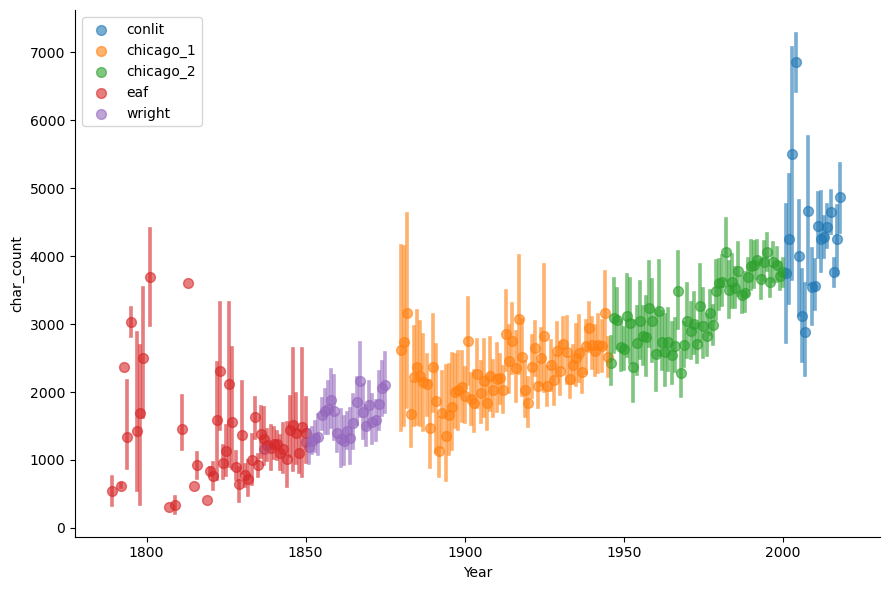

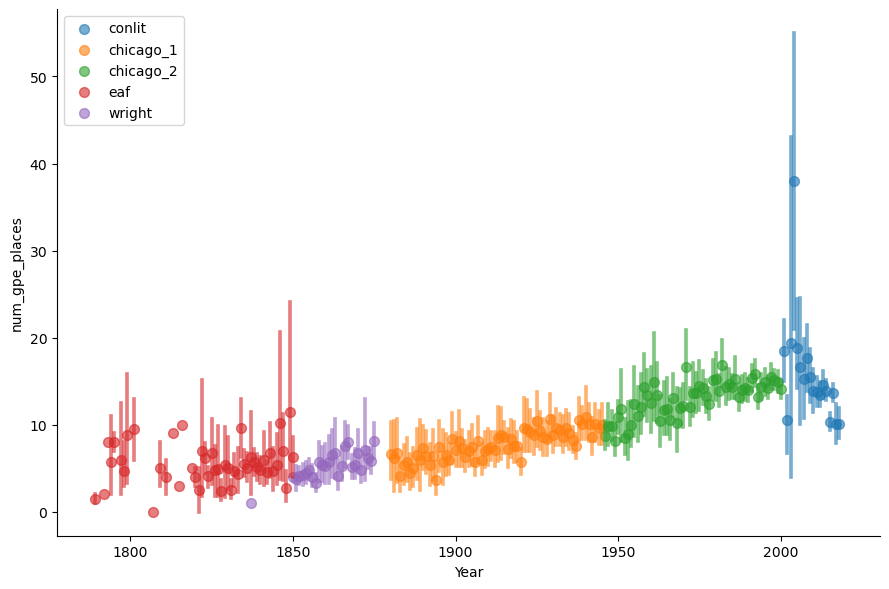

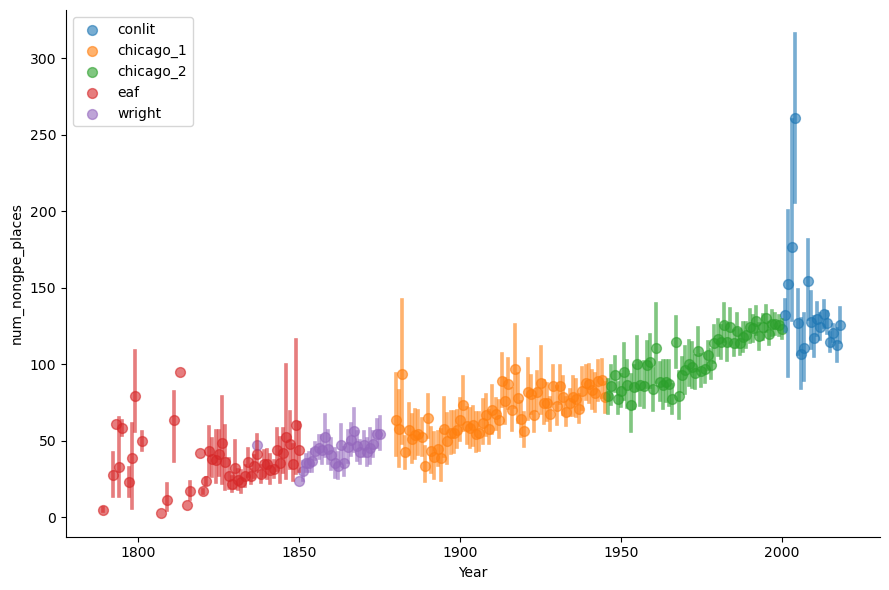

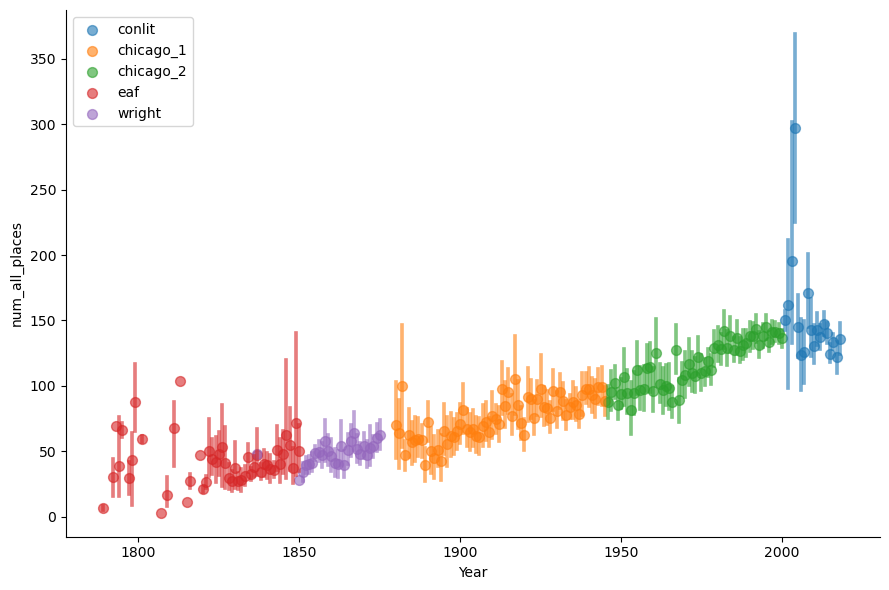

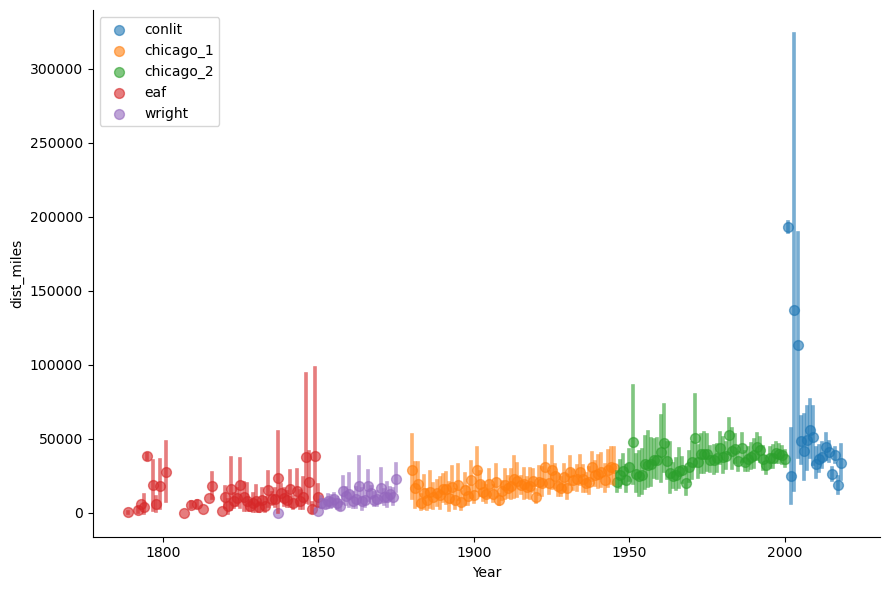

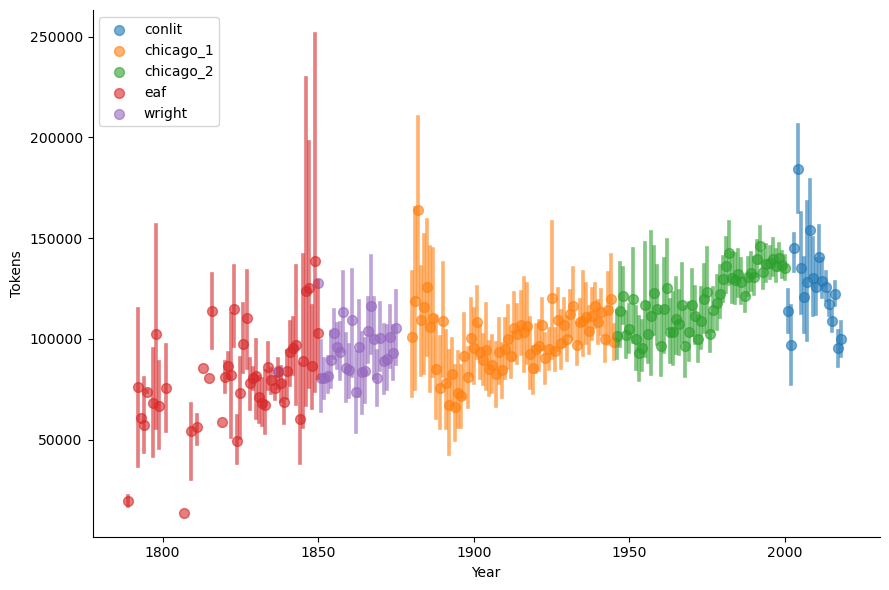

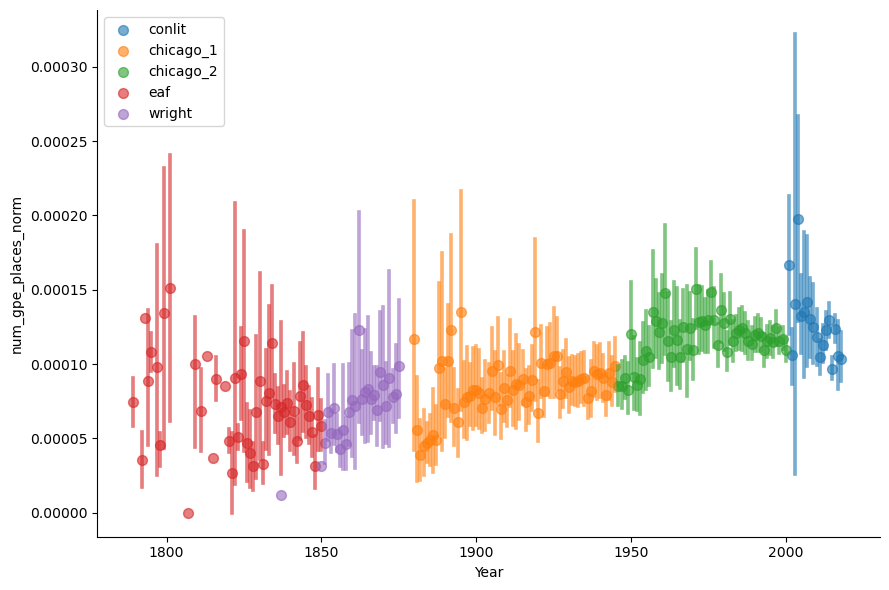

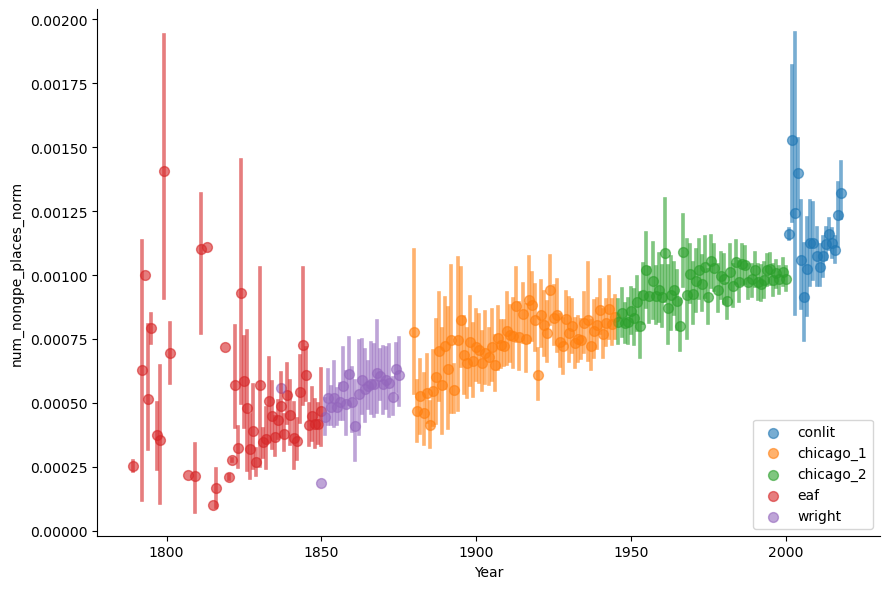

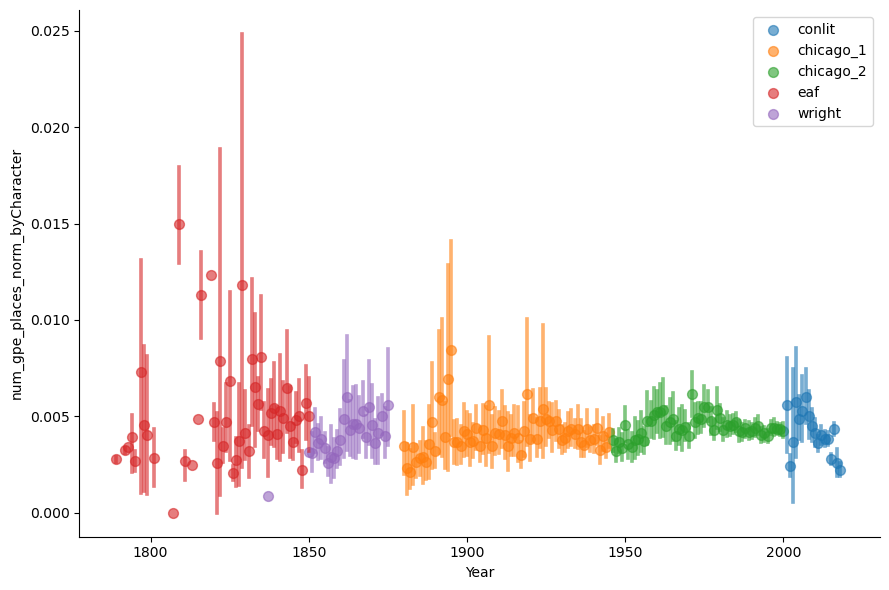

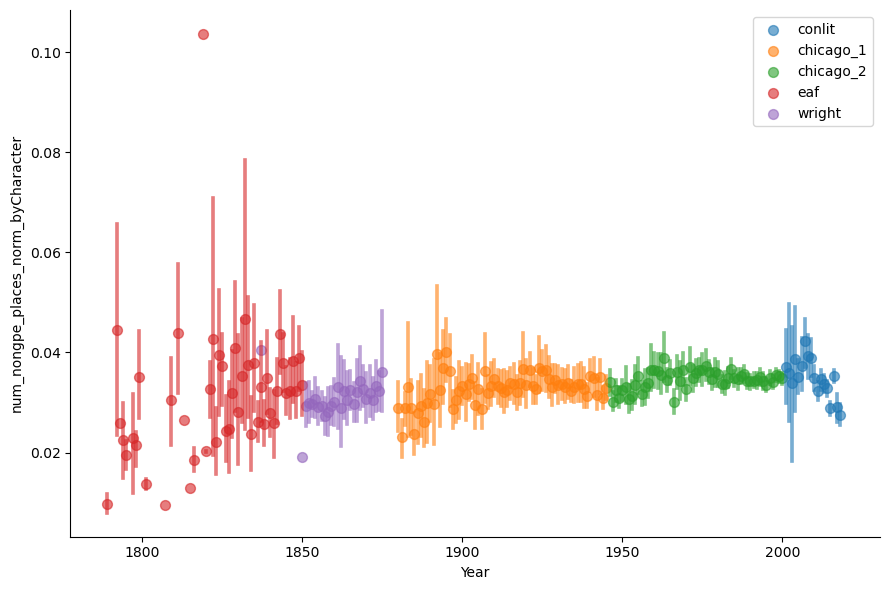

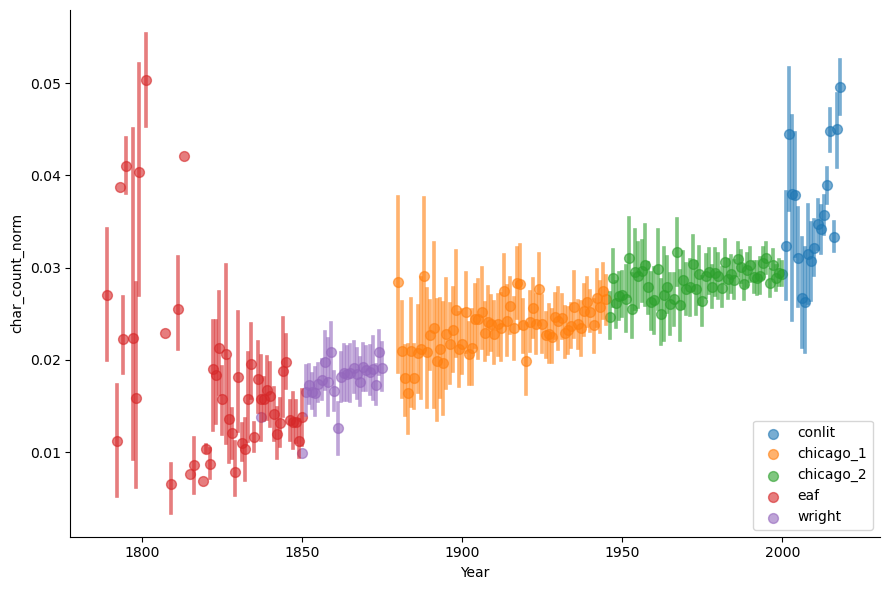

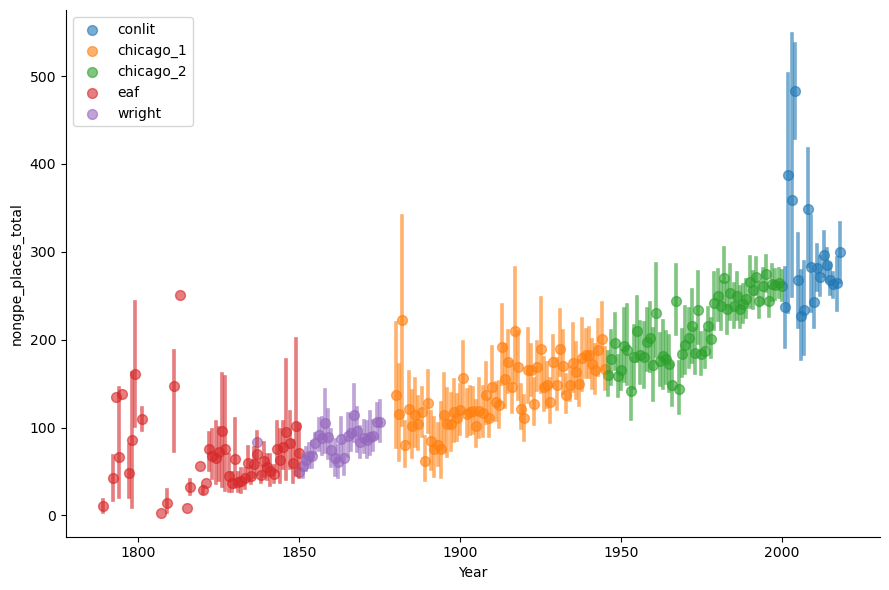

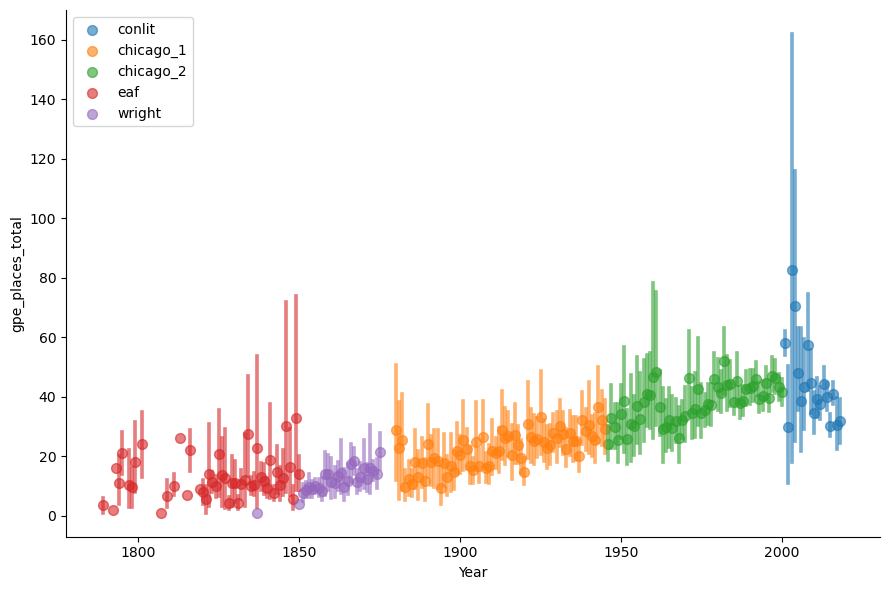

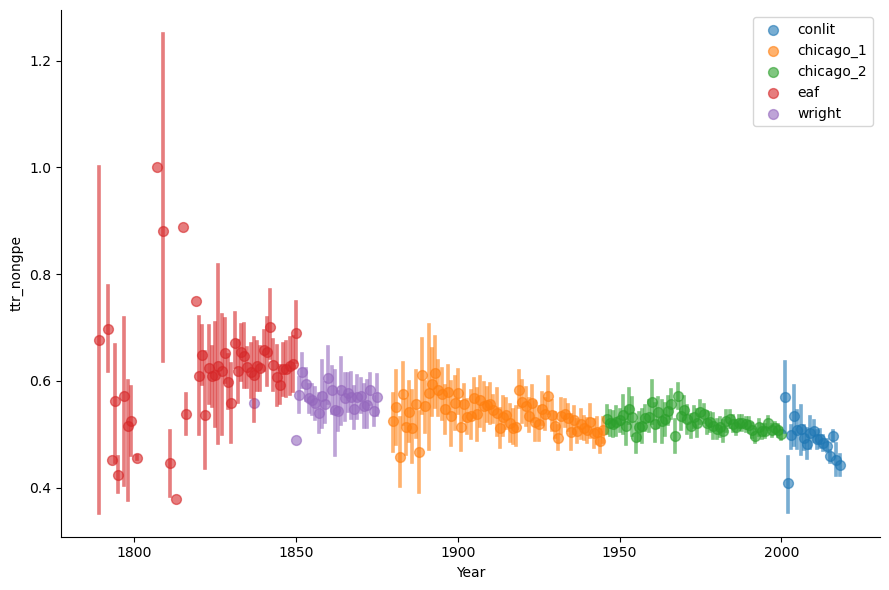

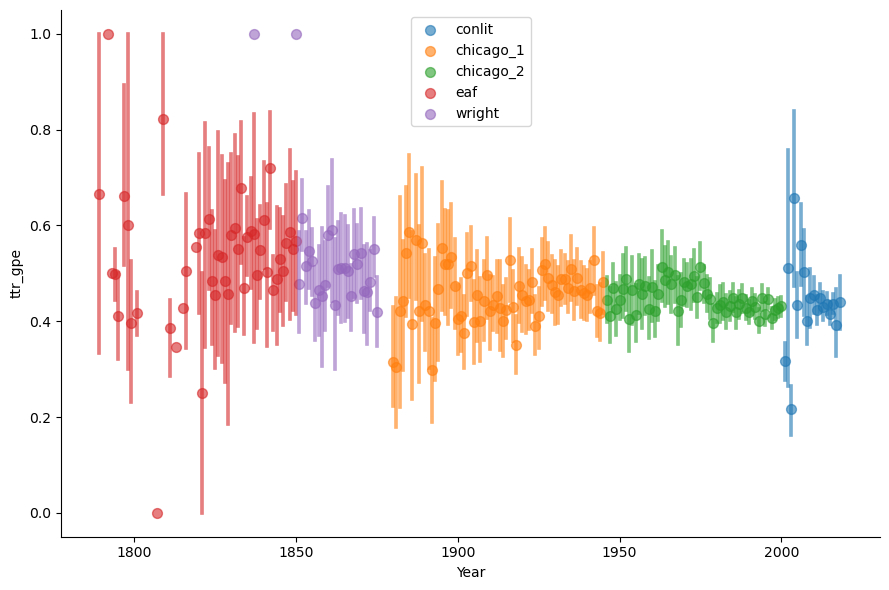

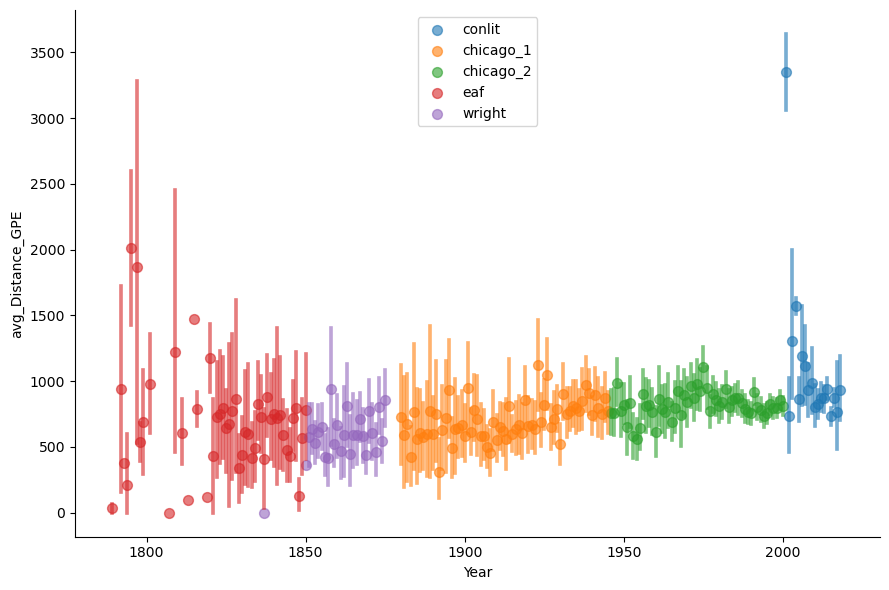

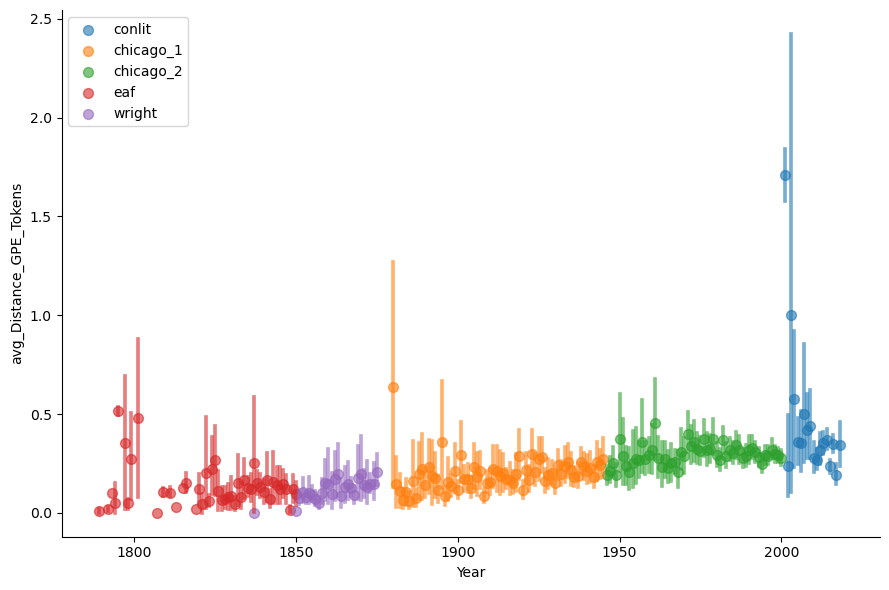

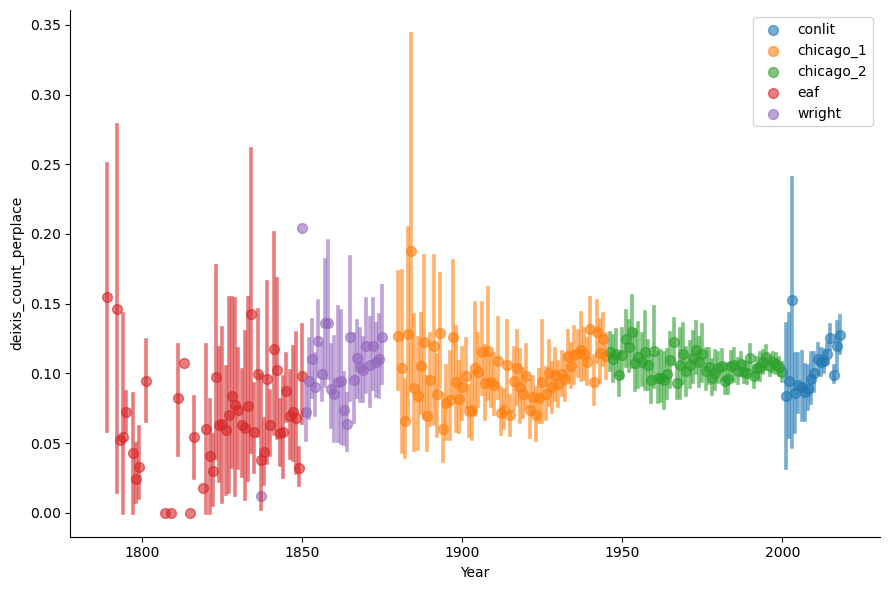

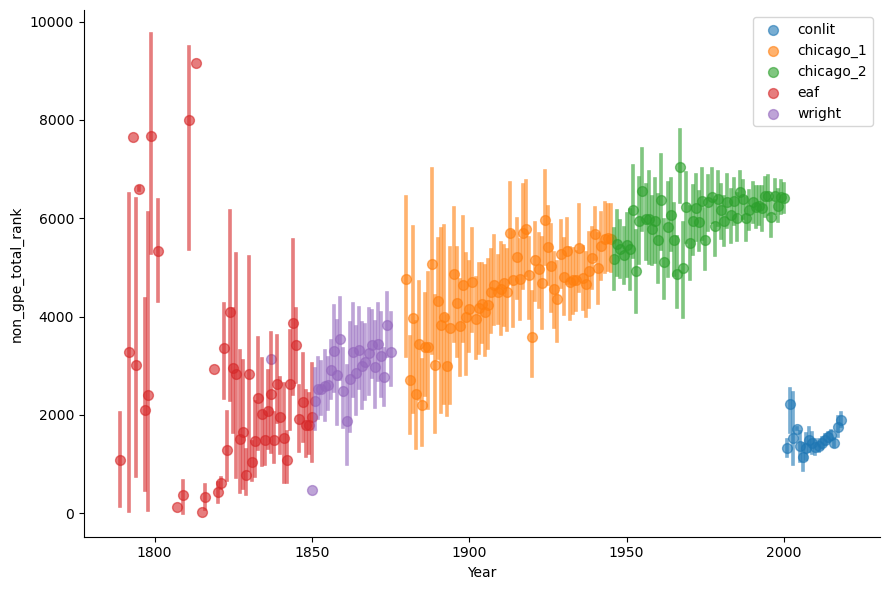

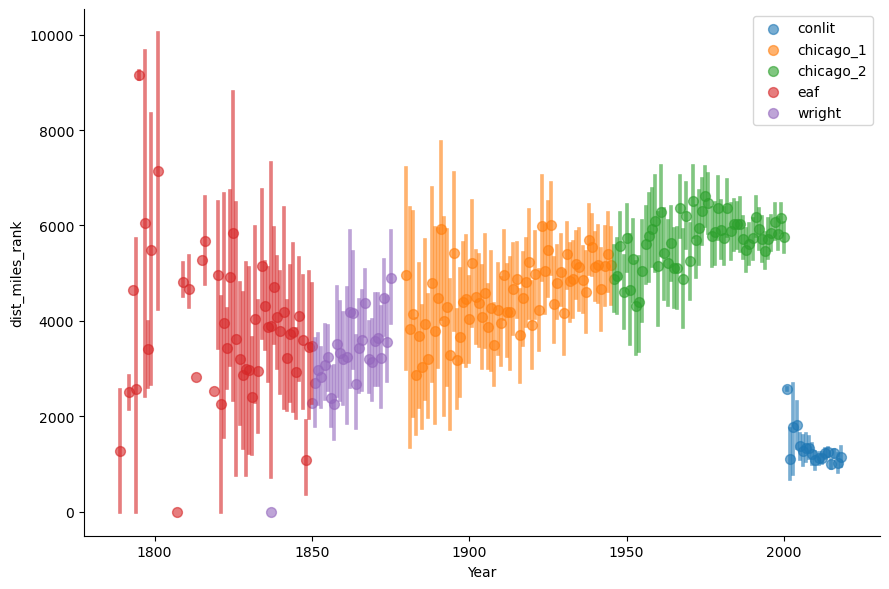

In [7]:
# plot features over time

# restrict to fiction
fic_data = data.loc[data.Category=='FIC']

# use all informative numeric columns
cols_to_drop_from_plot = ['char_id', 'char_rank', 'pub_date']
numeric_cols = fic_data[fic_data.columns[fic_data.notna().all()]].select_dtypes(include='number').drop(columns=cols_to_drop_from_plot).columns

# create plots
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = np.arange(fic_data.pub_date.min(), fic_data.pub_date.max(), 1)
    for col in numeric_cols:
        sns.lmplot(
            x='pub_date', 
            y=col, 
            data=fic_data, 
            #y_partial='Category', # control for fiction/nonfiction
            fit_reg=False,
            x_bins=bins, #fixed total bins by year
            #x_bins=10, # number of bins per collection
            hue='collection',
            legend=False,
            height=6,
            aspect=1.5,
            scatter_kws={'alpha':0.6}
        )
        plt.xlabel('Year')
        plt.ylabel(col)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()